# Business Case 4: Cryptocurrencies Forecasting

## Contents:
  
 * [Modeling ETH](#Modeling)
 * [ETH - Entire Dataset](#entiredataset)
    * [Model 1: LSTM](#lstm)
    * [Model 2: XGBOOST Regressor](#xgboost)
 * [ETH - since January 2021](#jan2021)
    * [Model 1: LSTM](#lstm2)
    * [Model 2: XGBOOST Regressor](#xgboost2)
 * [ETH - since January 2022](#jan2022)
    * [Model 1: LSTM](#lstm3)
    * [Model 2: XGBOOST Regressor](#xgboost3)
 * [Predictions for the next two days using the best model](#predictions)
 * [Final Predictions](#finalpredictions)

## Imports

In [1]:
#! pip install xgboost
#! pip install fastai==0.7.0
#! pip install --upgrade tensorflow
#! pip install keras
#! pip install pystan
#! pip install ephem
#! pip install fbprophet

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from math import ceil
import math
import scipy.stats as stats
from itertools import cycle

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly

import json
import requests
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error , mean_absolute_error, explained_variance_score, r2_score
from tensorflow.keras import layers
from xgboost import XGBRegressor

import warnings

# Modeling - ETH <a name="Modeling"></a>
>In this step, we decided to implement algorithms (LSTM, XGBOOST Regressor) that can predict the closing price of ETH.

# ETH - Entire Dataset <a name="entiredataset"></a>

In [3]:
eth = pd.read_csv('ETH.csv', index_col = 'Date')

In [4]:
eth.head()

,close,volume,%D,spread,volatility,close_off_high,EUR/USD_close
Date,,,,,,,
2017-11-24,0.082619,0.016150,0.962476,0.051878,0.423834,0.993797,0.645889
2017-11-25,0.080792,0.005727,0.931036,0.015445,0.103198,0.980644,0.645889
2017-11-26,0.081861,0.003042,0.944501,0.013409,0.090663,0.998575,0.645889
2017-11-27,0.083770,0.005421,0.930661,0.015971,0.108052,0.986646,0.685035
2017-11-28,0.082194,0.004822,0.924060,0.010051,0.063547,0.990199,0.673386


# Model 1: LSTM <a name="lstm"></a>

In [5]:
data = eth.copy()
data.head()

,close,volume,%D,spread,volatility,close_off_high,EUR/USD_close
Date,,,,,,,
2017-11-24,0.082619,0.016150,0.962476,0.051878,0.423834,0.993797,0.645889
2017-11-25,0.080792,0.005727,0.931036,0.015445,0.103198,0.980644,0.645889
2017-11-26,0.081861,0.003042,0.944501,0.013409,0.090663,0.998575,0.645889
2017-11-27,0.083770,0.005421,0.930661,0.015971,0.108052,0.986646,0.685035
2017-11-28,0.082194,0.004822,0.924060,0.010051,0.063547,0.990199,0.673386


In [6]:
#Splitting the original dataset using all the variables (hist) and "close" (target) using 7 days a the length of the sliding window

hist = []
target = []
length = 7

for i in range(len(data)-length):
    t = data['close']
    v = data[['close', 'volume', 'spread','volatility', 'close_off_high', 'EUR/USD_close']]
    x = v[i:i+length]
    y = t[i+length]
    hist.append(x)
    target.append(y)

In [7]:
print(len(hist[0]))  #nr of days
print(len(hist)) #size of train dataset
print(len(target)) #size of test dataset

7
1607
1607


In [8]:
#convert lists to arrays
hist = np.array(hist)
target = np.array(target)

In [9]:
target = target.reshape(-1,1)
target.shape

(1607, 1)

In [10]:
#Splitting the datasets into train and test using 80% for train and 20% for test

training_size=int(len(data)*0.80)

X_train = hist[:training_size,:]
X_test = hist[training_size:,:]

y_train = target[:training_size]
y_test = target[training_size:]

In [11]:
#Nr of instances, # nr of days (length), #nr of columns
X_train.shape

(1291, 7, 6)

In [12]:
model = tf.keras.Sequential()

model.add(layers.LSTM(units=20, activation = 'relu', return_sequences=True,
                  input_shape=(7,6), dropout = 0.2))

model.add(layers.LSTM(units=32, return_sequences=True,
                  dropout=0.2))

model.add(layers.LSTM(units=40, activation = 'relu', dropout=0.2))

#model.add(layers.LSTM(units=55, return_sequences = True, dropout = 0.2))

#model.add(layers.LSTM(units = 80, activation = 'relu', dropout = 0.2))

model.add(layers.Dense(units=1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 20)             2160      
                                                                 
 lstm_1 (LSTM)               (None, 7, 32)             6784      
                                                                 
 lstm_2 (LSTM)               (None, 40)                11680     
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
Total params: 20,665
Trainable params: 20,665
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [14]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, shuffle = False, validation_split=0.2)

Epoch 1/30
33/33 [==============================] - 5s 33ms/step - loss: 0.0044 - val_loss: 0.1179
Epoch 2/30
33/33 [==============================] - 0s 11ms/step - loss: 0.0033 - val_loss: 0.1064
Epoch 3/30
33/33 [==============================] - 0s 11ms/step - loss: 0.0027 - val_loss: 0.1041
Epoch 4/30
33/33 [==============================] - 0s 9ms/step - loss: 0.0026 - val_loss: 0.0984
Epoch 5/30
33/33 [==============================] - 0s 12ms/step - loss: 0.0022 - val_loss: 0.0926
Epoch 6/30
33/33 [==============================] - 0s 10ms/step - loss: 0.0021 - val_loss: 0.0830
Epoch 7/30
33/33 [==============================] - 0s 9ms/step - loss: 0.0017 - val_loss: 0.0692
Epoch 8/30
33/33 [==============================] - 0s 9ms/step - loss: 0.0013 - val_loss: 0.0532
Epoch 9/30
33/33 [==============================] - 0s 9ms/step - loss: 9.7144e-04 - val_loss: 0.0442
Epoch 10/30
33/33 [==============================] - 0s 10ms/step - loss: 8.6878e-04 - val_loss: 0.0480
Epoch

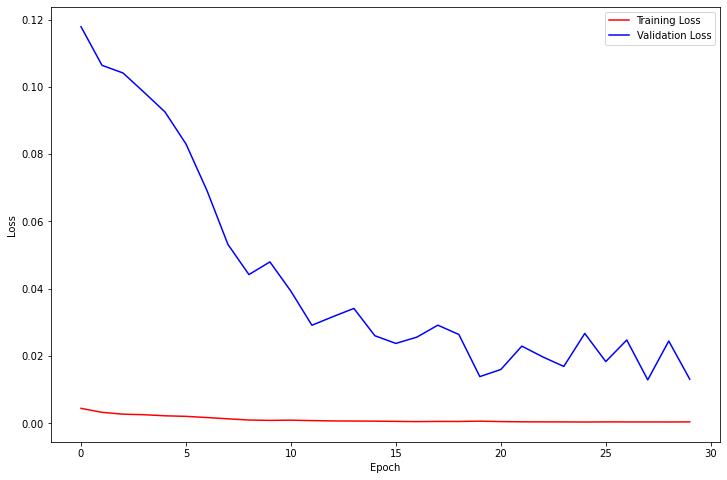

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_count = range(len(loss))
plt.figure(figsize=(12,8))
plt.plot(epoch_count, loss, 'r', label='Training loss')
plt.plot(epoch_count, val_loss, 'b', label='Validation loss')
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [16]:
pred_test = model.predict(X_test)
pred_train = model.predict (X_train)

In [17]:
results = np.concatenate((y_test, pred_test), axis=1)
results = pd.DataFrame(results, columns = ['y_test', 'Predictions'])
a = data['close'].tail(len(pred_test))
a = list(a.index)
results['Date'] = a
results['Date'] = pd.to_datetime(results['Date'])
results.tail()

,y_test,Predictions,Date
311,0.614067,0.363521,2022-04-21
312,0.609277,0.362414,2022-04-22
313,0.603625,0.366621,2022-04-23
314,0.600372,0.369600,2022-04-24
315,0.618702,0.372033,2022-04-25


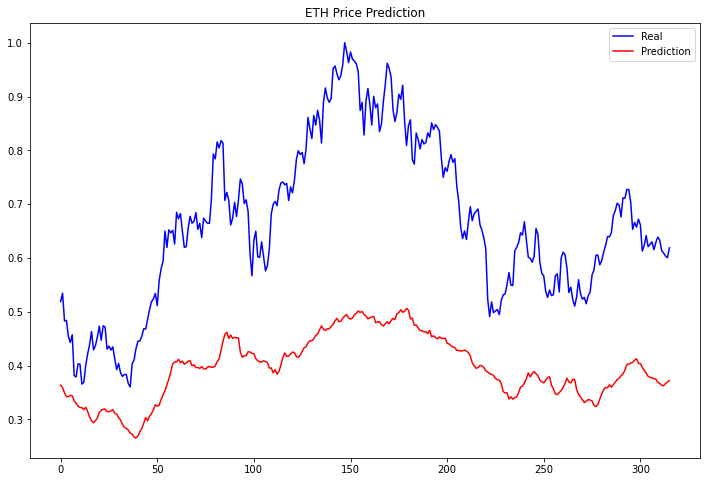

In [18]:
plt.figure(figsize=(12,8))
plt.plot(y_test, color='blue', label='Real')
plt.plot(pred_test, color='red', label='Prediction')
plt.title('ETH Price Prediction')
plt.legend()
plt.show()

In [19]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,pred_train)))
print("Train data MSE: ", mean_squared_error(y_train,pred_train))
print("Train data MAE: ", mean_absolute_error(y_train,pred_train))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,pred_test)))
print("Test data MSE: ", mean_squared_error(y_test,pred_test))
print("Test data MAE: ", mean_absolute_error(y_test,pred_test))

Train data RMSE:  0.05346768306854077
Train data MSE:  0.0028587931327179214
Train data MAE:  0.025635289910384603
-------------------------------------------------------------------------------------
Test data RMSE:  0.28593214106361187
Test data MSE:  0.08175718929322125
Test data MAE:  0.26717489849625736


In [20]:
print("Train data R2 score:", r2_score(y_train, pred_train))
print("Test data R2 score:", r2_score(y_test, pred_test))

Train data R2 score: 0.8570936247455223
Test data R2 score: -2.4740007451788544


# Model 2: XGBoost Regressor  <a name="xgboost"></a>

In [21]:
data1 = eth.copy()
data1.reset_index(inplace = True)
data1.shape

(1614, 8)

In [22]:
close_stock = data1.copy()
print("Total data for prediction: ",data1.shape[0])

Total data for prediction:  1614


In [23]:
data1.set_index('Date', inplace = True)
data1.shape

(1614, 7)

In [24]:
#Train and test split using 80% for train and 20% for test
training_size=int(len(data1)*0.80)
test_size=len(data1)-training_size
train_data,test_data=data1.iloc[:training_size,:],data1.iloc[training_size:,:]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (1291, 7)
test_data:  (323, 7)


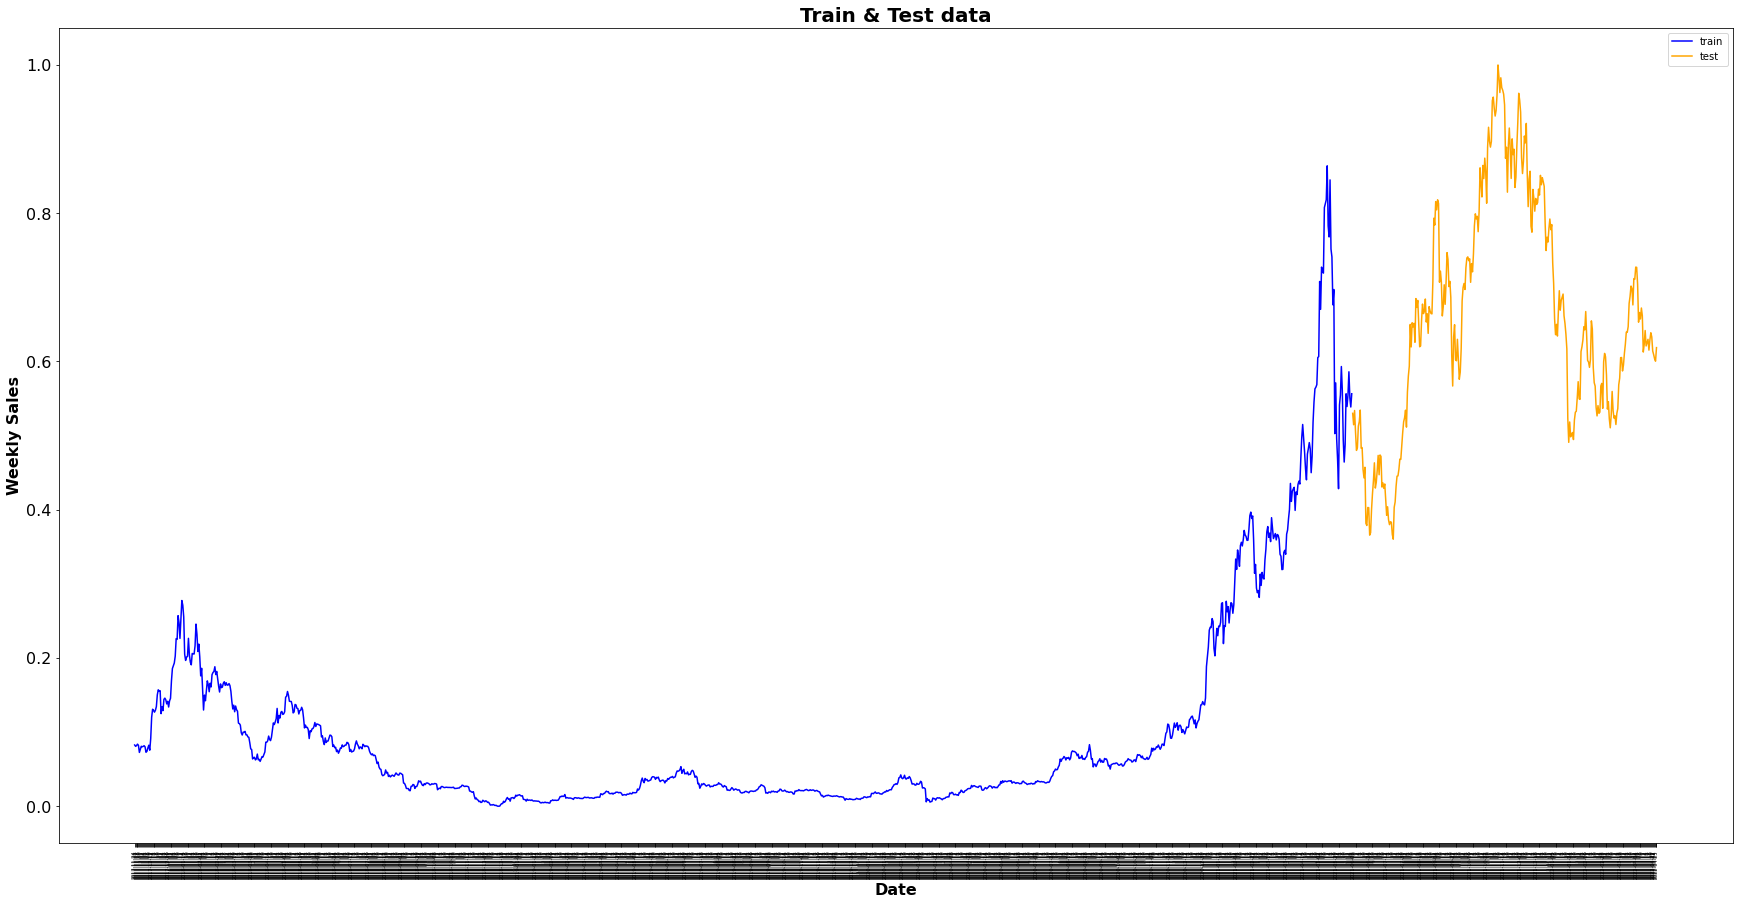

In [25]:
data1.reset_index(inplace = True)
fig, ax = plt.subplots(figsize=(30, 15))
sns.lineplot(x = close_stock['Date'][:training_size], y = close_stock['close'][:training_size], color = 'blue')
sns.lineplot(x = close_stock['Date'][training_size:], y = close_stock['close'][training_size:], color = 'orange')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', labelsize=5)
plt.xticks(rotation='vertical')
plt.legend(loc='upper right' ,labels = ('train', 'test'))
plt.show()

In [26]:
data1.set_index('Date', inplace = True)

In [27]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset.iloc[i:(i+time_step), 0:]   
        dataX.append(a)
        dataY.append(dataset.iloc[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [28]:
#Sliding window = 7 or 20
time_step = 7
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (1283, 7, 7)
y_train:  (1283,)
X_test:  (315, 7, 7)
y_test (315,)


In [29]:
#Reshaping the arrays because XGBRegressor only accepts 1-Dimensional arrays
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))

In [30]:
model1 = XGBRegressor(n_estimators=100, random_state = 1, eta = 0.2)
model1.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.2,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.200000003, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=1, reg_alpha=0, ...)

In [31]:
predictions = model1.predict(X_test).reshape(-1,1)
y_test = y_test.reshape(-1,1)

predictions_train = model1.predict(X_train)

In [32]:
results2 = np.concatenate((y_test, predictions),axis = 1)
results2 = pd.DataFrame(results2, columns = ['y_test', 'Predictions'])
a = data1['close'].tail(len(predictions))
a = list(a.index)
results2['Date'] = a
results2['Date'] = pd.to_datetime(results2['Date'])
results2.tail()

,y_test,Predictions,Date
310,0.633159,0.625108,2022-04-21
311,0.614067,0.625737,2022-04-22
312,0.609277,0.621973,2022-04-23
313,0.603625,0.624148,2022-04-24
314,0.600372,0.585324,2022-04-25


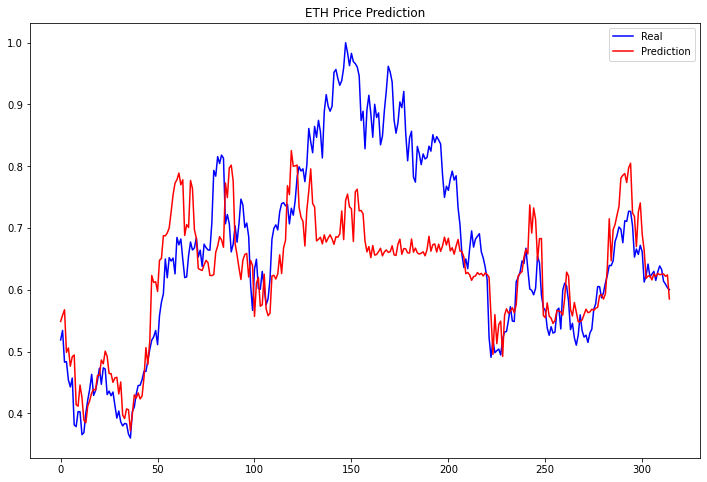

In [33]:
plt.figure(figsize=(12,8))
plt.plot(y_test, color='blue', label='Real')
plt.plot(predictions, color='red', label='Prediction')
plt.title('ETH Price Prediction')
plt.legend()
plt.show()

In [34]:
print("Train data MSE: ", mean_squared_error(y_train,predictions_train))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_train, predictions_train)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_train, predictions_train))))
print('R^2 Score', r2_score(y_train, predictions_train))

print ("--------------------------------------------------------------")
print("Test data MSE: ", mean_squared_error(y_test,predictions))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))
print('R^2 Score', r2_score(y_test, predictions))

Train data MSE:  4.779425796080903e-07
Mean Absolute Error - MAE : 0.0004915799138824172
Root Mean squared Error - RMSE : 0.0006913339132489382
R^2 Score 0.9999749017477364
--------------------------------------------------------------
Test data MSE:  0.011962454569690837
Mean Absolute Error - MAE : 0.08023016281359222
Root Mean squared Error - RMSE : 0.10937300658613548
R^2 Score 0.4931646699659864


# ETH - since January 2021  <a name="jan2021"></a>

# Model 1: LSTM <a name="lstm2"></a>

In [35]:
data2 = eth.copy()
data2.reset_index(inplace = True)
data2 = data2[data2['Date'] >= '2021-01-01']
data2.set_index('Date', inplace = True)
print("Total data for prediction: ",data2.shape[0])

Total data for prediction:  480


In [36]:
hist = []
target = []
length = 7

for i in range(len(data2)-length):
    t = data2['close']
    v = data2[['close','volume','spread', 'volatility', 'close_off_high', 'EUR/USD_close']]
    x = v[i:i+length]
    y = t[i+length]
    hist.append(x)
    target.append(y)

In [37]:
print(len(hist[0]))
print(len(hist))
print(len(target))

7
473
473


In [38]:
#convert list to array
hist = np.array(hist)
target = np.array(target)

In [39]:
target = target.reshape(-1,1)
target.shape

(473, 1)

In [40]:
training_size = int(len(data2)*0.8)

X_train = hist[:training_size,:]
X_test = hist[training_size:,:]

y_train = target[:training_size]
y_test = target[training_size:]

In [41]:
X_train.shape

(384, 7, 6)

In [42]:
model2 = tf.keras.Sequential()

model2.add(layers.LSTM(units=20, activation = 'relu', return_sequences=True,
                  input_shape=(7,6), dropout = 0.2))

model2.add(layers.LSTM(units=32, return_sequences=True,
                  dropout=0.2))

model2.add(layers.LSTM(units=32, activation = 'relu', dropout=0.2))

#model.add(layers.LSTM(units=55, return_sequences = True, dropout = 0.2))

#model.add(layers.LSTM(units = 80, activation = 'relu', dropout = 0.2))

model2.add(layers.Dense(units=1))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 7, 20)             2160      
                                                                 
 lstm_4 (LSTM)               (None, 7, 32)             6784      
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 17,297
Trainable params: 17,297
Non-trainable params: 0
_________________________________________________________________


In [43]:
model2.compile(optimizer='adam', loss='mean_squared_error')

In [44]:
history = model2.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, shuffle = False)

Epoch 1/30
10/10 [==============================] - 4s 68ms/step - loss: 0.2450 - val_loss: 0.4506
Epoch 2/30
10/10 [==============================] - 0s 11ms/step - loss: 0.1119 - val_loss: 0.2060
Epoch 3/30
10/10 [==============================] - 0s 10ms/step - loss: 0.0206 - val_loss: 0.0453
Epoch 4/30
10/10 [==============================] - 0s 10ms/step - loss: 0.0643 - val_loss: 0.0994
Epoch 5/30
10/10 [==============================] - 0s 10ms/step - loss: 0.0412 - val_loss: 0.1109
Epoch 6/30
10/10 [==============================] - 0s 10ms/step - loss: 0.0306 - val_loss: 0.0763
Epoch 7/30
10/10 [==============================] - 0s 10ms/step - loss: 0.0352 - val_loss: 0.0647
Epoch 8/30
10/10 [==============================] - 0s 10ms/step - loss: 0.0322 - val_loss: 0.0633
Epoch 9/30
10/10 [==============================] - 0s 10ms/step - loss: 0.0304 - val_loss: 0.0584
Epoch 10/30
10/10 [==============================] - 0s 10ms/step - loss: 0.0262 - val_loss: 0.0474
Epoch 11/

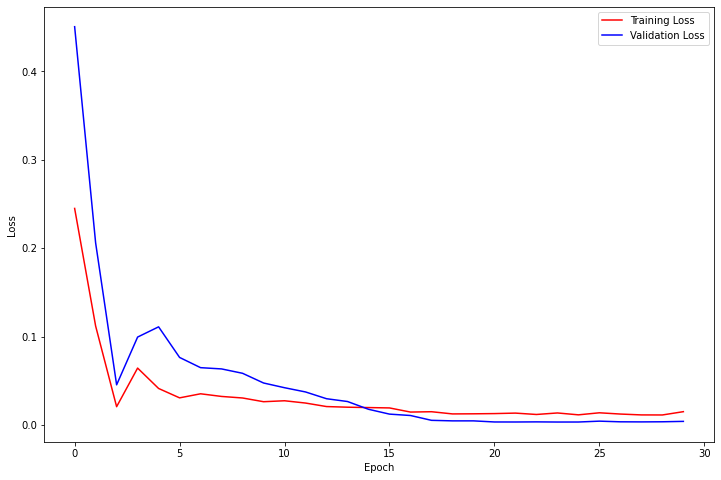

In [45]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_count = range(len(loss))
plt.figure(figsize=(12,8))
plt.plot(epoch_count, loss, 'r', label='Training loss')
plt.plot(epoch_count, val_loss, 'b', label='Validation loss')
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [46]:
pred_test = model2.predict(X_test)
pred_train = model2.predict (X_train)

In [47]:
results = np.concatenate((y_test, pred_test), axis=1)
results = pd.DataFrame(results, columns = ['y_test', 'Predictions'])
a = data2['close'].tail(len(pred_test))
a = list(a.index)
results['Date'] = a
results['Date'] = pd.to_datetime(results['Date'])
results.tail()
results.head()

,y_test,Predictions,Date
0,0.494671,0.528650,2022-01-27
1,0.520918,0.505651,2022-01-28
2,0.531492,0.507407,2022-01-29
3,0.532842,0.515389,2022-01-30
4,0.550781,0.514593,2022-01-31


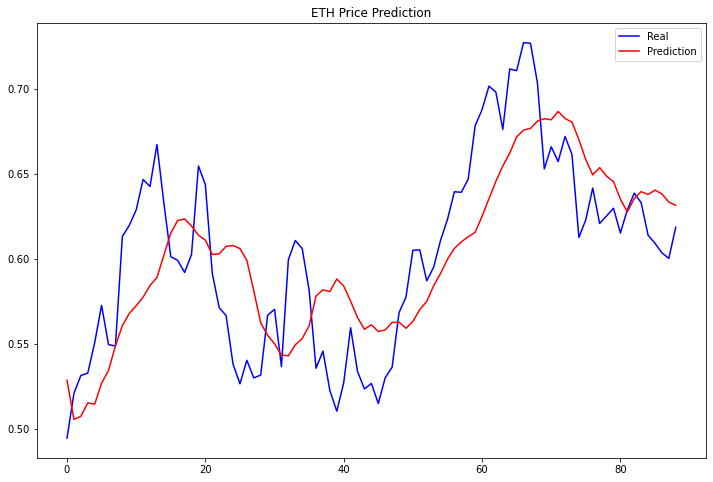

In [48]:
plt.figure(figsize=(12,8))
plt.plot(y_test, color='blue', label='Real')
plt.plot(pred_test, color='red', label='Prediction')
plt.title('ETH Price Prediction')
plt.legend()
plt.show()

In [49]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,pred_train)))
print("Train data MSE: ", mean_squared_error(y_train,pred_train))
print("Train data MAE: ", mean_absolute_error(y_train,pred_train))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,pred_test)))
print("Test data MSE: ", mean_squared_error(y_test,pred_test))
print("Test data MAE: ", mean_absolute_error(y_test,pred_test))

Train data RMSE:  0.07633097884453988
Train data MSE:  0.005826418331365594
Train data MAE:  0.060465415883477924
-------------------------------------------------------------------------------------
Test data RMSE:  0.038990743062045245
Test data MSE:  0.0015202780445304294
Test data MAE:  0.03392671673012298


In [50]:
print("Train data R2 score:", r2_score(y_train, pred_train))
print("Test data R2 score:", r2_score(y_test, pred_test))

Train data R2 score: 0.8634579632230694
Test data R2 score: 0.5240978962488063


# Model 2: XGBoost Regressor   <a name="xgboost2"></a>

In [51]:
data3 = eth.copy()

In [52]:
data3.reset_index(inplace = True)
data3 = data3[data3['Date'] >= '2021-01-01']               
data3.set_index('Date', inplace = True)
print("Total data for prediction: ",data3.shape[0])

Total data for prediction:  480


In [53]:
data3.shape

(480, 7)

In [54]:
training_size=int(len(data3)*0.80)
test_size=len(data3)-training_size
train_data,test_data=data3.iloc[:training_size,:],data3.iloc[training_size:,:]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (384, 7)
test_data:  (96, 7)


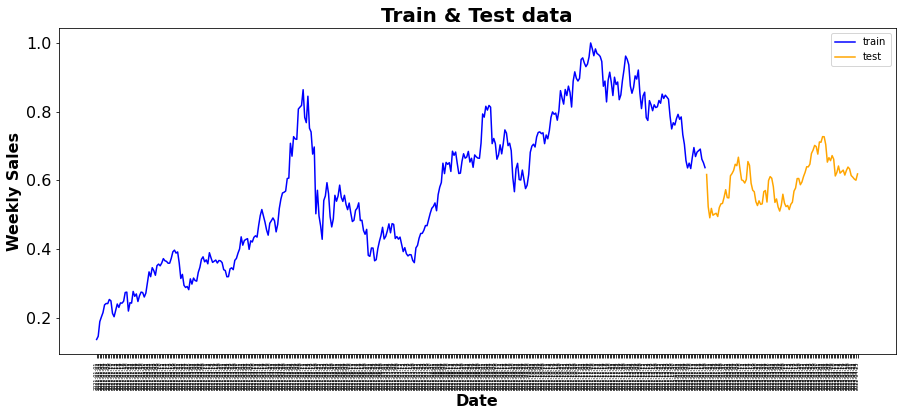

In [55]:
data3.reset_index(inplace = True)
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = data3['Date'][:training_size], y = data3['close'][:training_size], color = 'blue')
sns.lineplot(x = data3['Date'][training_size:], y =data3['close'][training_size:], color = 'orange')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=5)
plt.xticks(rotation = 'vertical')
plt.legend(loc='upper right' ,labels = ('train', 'test'))
plt.show()

In [56]:
data3.set_index('Date', inplace = True)

In [57]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset.iloc[i:(i+time_step), :]   
        dataX.append(a)
        dataY.append(dataset.iloc[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [58]:
time_step = 7
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (376, 7, 7)
y_train:  (376,)
X_test:  (88, 7, 7)
y_test (88,)


In [59]:
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))

In [60]:
model3 = XGBRegressor(n_estimators=1000, random_state = 1, eta = 0.2)
model3.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.2,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.200000003, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
             reg_alpha=0, ...)

In [61]:
predictions = model3.predict(X_test).reshape(-1,1)
y_test = y_test.reshape(-1,1)

predictions_train = model3.predict(X_train).reshape(-1,1)
y_train = y_train.reshape(-1,1)

In [62]:
results2 = np.concatenate((y_test, predictions), axis = 1)
results2 = pd.DataFrame(results2, columns = ['y_test', 'Predictions'])
a = data3['close'].tail(len(predictions))
a = list(a.index)
results2['Date'] = a
results2['Date'] = pd.to_datetime(results2['Date'])
results2.tail()

,y_test,Predictions,Date
83,0.633159,0.648992,2022-04-21
84,0.614067,0.633975,2022-04-22
85,0.609277,0.636036,2022-04-23
86,0.603625,0.628448,2022-04-24
87,0.600372,0.619142,2022-04-25


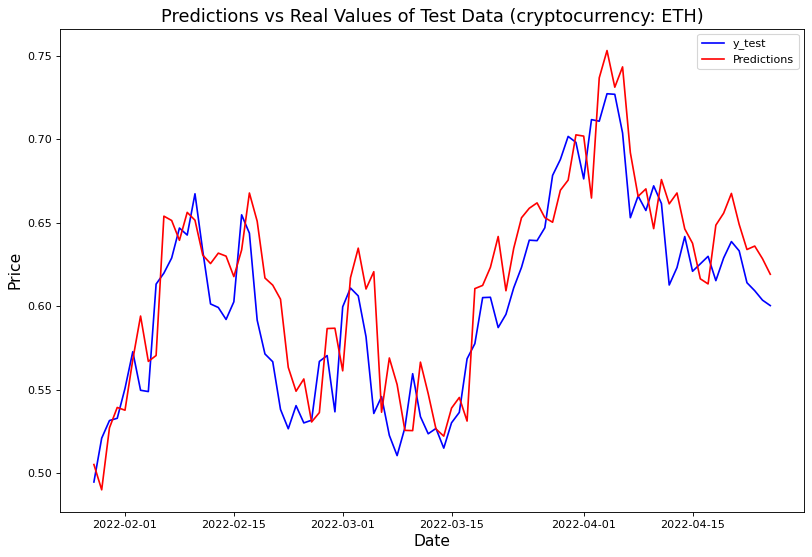

In [63]:
plt.figure(figsize = (12,8), dpi = 80)
plt.plot(results2['Date'], results2['y_test'], 'b', label = 'y_test')
plt.plot(results2['Date'], results2['Predictions'], 'r', label = 'Predictions')
plt.title ('Predictions vs Real Values of Test Data (cryptocurrency: ETH)', fontsize = 16, )
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Price', fontsize = 14)
plt.legend()

plt.show()

In [64]:
print("Train data MSE: ", mean_squared_error(y_train,predictions_train))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_train, predictions_train)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_train, predictions_train))))
print('R^2 Score', r2_score(y_train, predictions_train))

print ("--------------------------------------------------------------")
print("Test data MSE: ", mean_squared_error(y_test,predictions))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))
print('R^2 Score', r2_score(y_test, predictions))

Train data MSE:  3.0848688693610313e-07
Mean Absolute Error - MAE : 0.00040834831540854813
Root Mean squared Error - RMSE : 0.0005554159584816618
R^2 Score 0.9999929039573638
--------------------------------------------------------------
Test data MSE:  0.0008619310661284942
Mean Absolute Error - MAE : 0.024472245928633143
Root Mean squared Error - RMSE : 0.029358662539844933
R^2 Score 0.7329699549093285


# ETH - since January 2022  <a name="jan2022"></a>

# Model 1: LSTM <a name="lstm3"></a>

In [65]:
data4 = eth.copy()
data4.reset_index(inplace = True)
data4 = data4[data4['Date'] >= '2022-01-01']
data4.set_index('Date', inplace = True)
print("Total data for prediction: ",data4.shape[0])

Total data for prediction:  115


In [66]:
hist = []
target = []
length = 7

for i in range(len(data4)-length):
    t = data4['close']
    v = data4[['close','volume', 'spread', 'volatility', 'close_off_high', 'EUR/USD_close']]
    x = v[i:i+length]
    y = t[i+length]
    hist.append(x)
    target.append(y)

In [67]:
print(len(hist[0]))
print(len(hist))
print(len(target))

7
108
108


In [68]:
#convert list to array
hist = np.array(hist)
target = np.array(target)

In [69]:
target = target.reshape(-1,1)
target.shape

(108, 1)

In [70]:
training_size = int(len(data4)*0.8)

X_train = hist[:training_size,:]
X_test = hist[training_size:,:]

y_train = target[:training_size]
y_test = target[training_size:]

In [71]:
X_train.shape

(92, 7, 6)

In [72]:
model4 = tf.keras.Sequential()

model4.add(layers.LSTM(units=20, activation = 'relu', return_sequences=True,
                  input_shape=(7,6), dropout = 0.2))

model4.add(layers.LSTM(units=32, return_sequences=True,
                  dropout=0.2))

model4.add(layers.LSTM(units=32, activation = 'relu', dropout=0.2))

#model.add(layers.LSTM(units=55, return_sequences = True, dropout = 0.2))

#model.add(layers.LSTM(units = 80, activation = 'relu', dropout = 0.2))

model4.add(layers.Dense(units=1))

model4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 7, 20)             2160      
                                                                 
 lstm_7 (LSTM)               (None, 7, 32)             6784      
                                                                 
 lstm_8 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 17,297
Trainable params: 17,297
Non-trainable params: 0
_________________________________________________________________


In [73]:
model4.compile(optimizer='adam', loss='mean_squared_error')

In [74]:
history = model4.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, shuffle = False)

Epoch 1/30
3/3 [==============================] - 4s 250ms/step - loss: 0.3491 - val_loss: 0.4267
Epoch 2/30
3/3 [==============================] - 0s 20ms/step - loss: 0.3128 - val_loss: 0.3873
Epoch 3/30
3/3 [==============================] - 0s 21ms/step - loss: 0.2793 - val_loss: 0.3482
Epoch 4/30
3/3 [==============================] - 0s 20ms/step - loss: 0.2418 - val_loss: 0.3032
Epoch 5/30
3/3 [==============================] - 0s 20ms/step - loss: 0.2037 - val_loss: 0.2503
Epoch 6/30
3/3 [==============================] - 0s 18ms/step - loss: 0.1539 - val_loss: 0.1859
Epoch 7/30
3/3 [==============================] - 0s 17ms/step - loss: 0.1080 - val_loss: 0.1119
Epoch 8/30
3/3 [==============================] - 0s 20ms/step - loss: 0.0504 - val_loss: 0.0385
Epoch 9/30
3/3 [==============================] - 0s 17ms/step - loss: 0.0157 - val_loss: 0.0010
Epoch 10/30
3/3 [==============================] - 0s 18ms/step - loss: 0.0229 - val_loss: 0.0065
Epoch 11/30
3/3 [===========

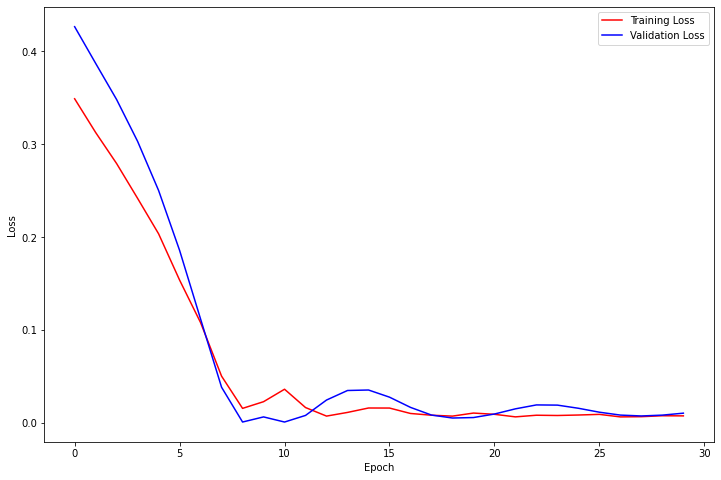

In [75]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_count = range(len(loss))
plt.figure(figsize=(12,8))
plt.plot(epoch_count, loss, 'r', label='Training loss')
plt.plot(epoch_count, val_loss, 'b', label='Validation loss')
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [76]:
pred_test = model4.predict(X_test)
pred_train = model4.predict (X_train)

In [77]:
results = np.concatenate((y_test, pred_test), axis=1)
results = pd.DataFrame(results, columns = ['y_test', 'Predictions'])
a = data4['close'].tail(len(pred_test))
a = list(a.index)
results['Date'] = a
results['Date'] = pd.to_datetime(results['Date'])
results.tail()

,y_test,Predictions,Date
11,0.614067,0.576535,2022-04-21
12,0.609277,0.581788,2022-04-22
13,0.603625,0.578671,2022-04-23
14,0.600372,0.573169,2022-04-24
15,0.618702,0.572486,2022-04-25


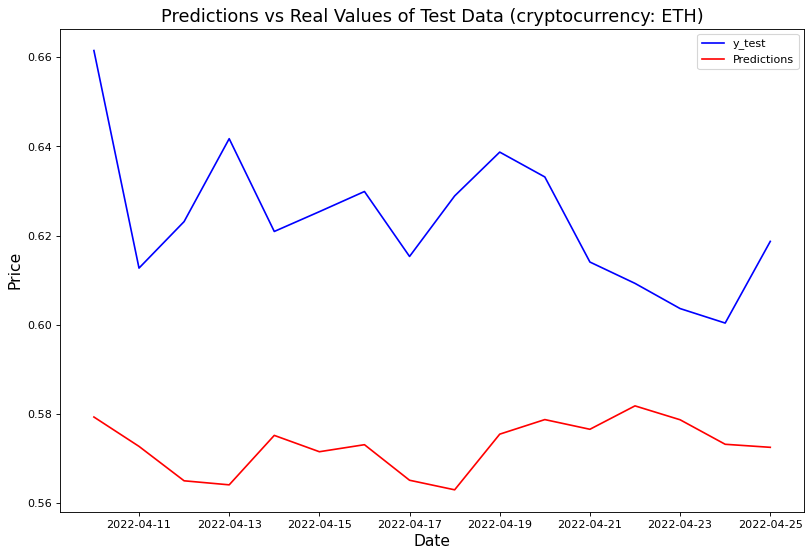

In [78]:
plt.figure(figsize = (12,8), dpi = 80)
plt.plot(results['Date'], results['y_test'], 'b', label = 'y_test')
plt.plot(results['Date'], results['Predictions'], 'r', label = 'Predictions')
plt.title ('Predictions vs Real Values of Test Data (cryptocurrency: ETH)', fontsize = 16,)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Price', fontsize = 14)
plt.legend()

plt.show()

In [79]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,pred_train)))
print("Train data MSE: ", mean_squared_error(y_train,pred_train))
print("Train data MAE: ", mean_absolute_error(y_train,pred_train))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,pred_test)))
print("Test data MSE: ", mean_squared_error(y_test,pred_test))
print("Test data MAE: ", mean_absolute_error(y_test,pred_test))

Train data RMSE:  0.06620876778854981
Train data MSE:  0.004383600932078111
Train data MAE:  0.05427966496232342
-------------------------------------------------------------------------------------
Test data RMSE:  0.0533335769561833
Test data MSE:  0.002844470430941126
Test data MAE:  0.0507409393955027


In [80]:
print("Train data R2 score:", r2_score(y_train, pred_train))
print("Test data R2 score:", r2_score(y_test, pred_test))

Train data R2 score: -0.06119681039461011
Test data R2 score: -11.599102493950497


# Model 2: XGBoost Regressor   <a name="xgboost3"></a>

In [81]:
data5= eth.copy()
data5.reset_index(inplace = True)
data5 = data5[data5['Date'] >= '2022-01-01']
data5.set_index('Date', inplace = True)
print("Total data for prediction: ",data5.shape[0])

Total data for prediction:  115


In [82]:
training_size=int(len(data5)*0.80)
test_size=len(data5)-training_size
train_data,test_data=data5.iloc[:training_size,:],data5.iloc[training_size:,:]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (92, 7)
test_data:  (23, 7)


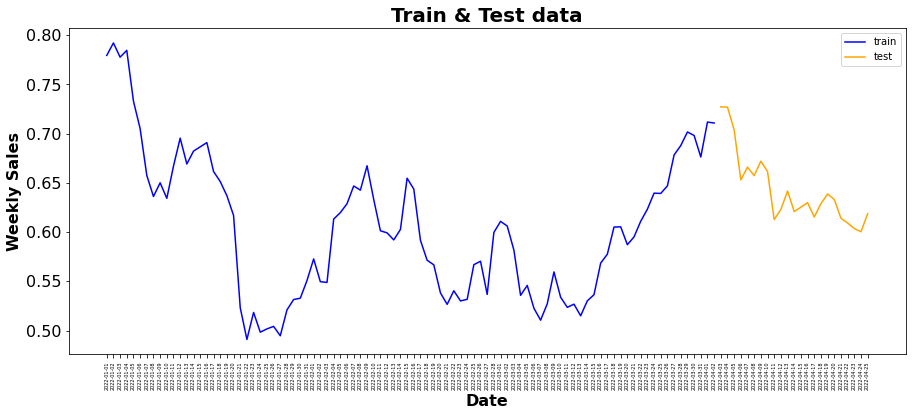

In [83]:
data5.reset_index(inplace = True)
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = data5['Date'][:training_size], y = data5['close'][:training_size], color = 'blue')
sns.lineplot(x = data5['Date'][training_size:], y = data5['close'][training_size:], color = 'orange')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=5)
plt.xticks(rotation = 'vertical')
plt.legend(loc='upper right' ,labels = ('train', 'test'))
plt.show()

In [84]:
data5.set_index('Date', inplace = True)

In [85]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset.iloc[i:(i+time_step), :]   
        dataX.append(a)
        dataY.append(dataset.iloc[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [86]:
time_step = 7
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (84, 7, 7)
y_train:  (84,)
X_test:  (15, 7, 7)
y_test (15,)


In [87]:
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))

In [88]:
model5 = XGBRegressor(n_estimators=1000, random_state = 1, eta = 0.2)
model5.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.2,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.200000003, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
             reg_alpha=0, ...)

In [89]:
predictions = model5.predict(X_test).reshape(-1,1)
y_test = y_test.reshape(-1,1)


predictions_train = model5.predict(X_train).reshape(-1,1)
y_train = y_train.reshape(-1,1)

In [90]:
results2 = np.concatenate((y_test, predictions), axis = 1)
results2 = pd.DataFrame(results2, columns = ['y_test', 'Predictions'])
a = data5['close'].tail(len(predictions))
a = list(a.index)
results2['Date'] = a
results2['Date'] = pd.to_datetime(results2['Date'])
results2.tail()

,y_test,Predictions,Date
10,0.633159,0.642739,2022-04-21
11,0.614067,0.639099,2022-04-22
12,0.609277,0.608521,2022-04-23
13,0.603625,0.626244,2022-04-24
14,0.600372,0.613055,2022-04-25


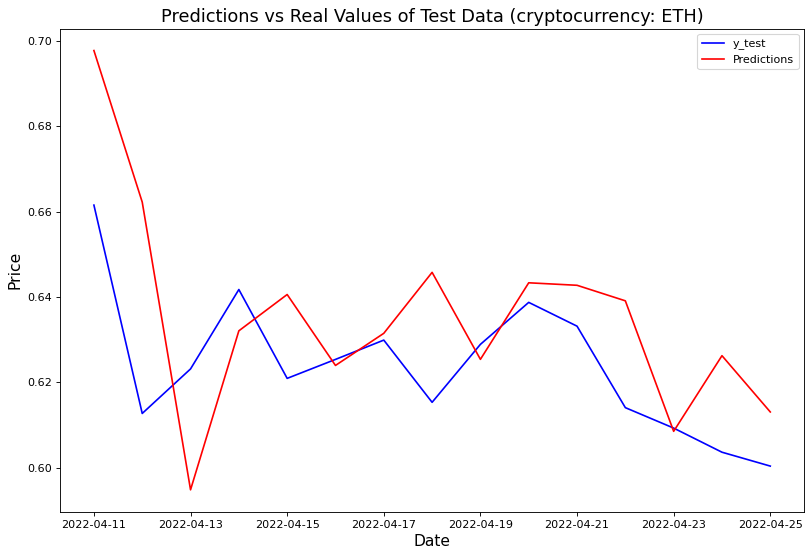

In [91]:
plt.figure(figsize = (12,8), dpi = 80 )
plt.plot(results2['Date'], results2['y_test'], 'b', label = 'y_test')
plt.plot(results2['Date'], results2['Predictions'], 'r', label = 'Predictions')
plt.title ('Predictions vs Real Values of Test Data (cryptocurrency: ETH)', fontsize = 16, )
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Price', fontsize = 14)
plt.legend()

plt.show()

In [92]:
print("Train data MSE: ", mean_squared_error(y_train,predictions_train))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_train, predictions_train)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_train, predictions_train))))
print('R^2 Score', r2_score(y_train, predictions_train))

print ("--------------------------------------------------------------")
print("Test data MSE: ", mean_squared_error(y_test,predictions))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))
print('R^2 Score', r2_score(y_test, predictions))

Train data MSE:  1.6210860164526654e-07
Mean Absolute Error - MAE : 0.0002908001762985602
Root Mean squared Error - RMSE : 0.00040262712482552206
R^2 Score 0.9999552138564888
--------------------------------------------------------------
Test data MSE:  0.0004935852146455401
Mean Absolute Error - MAE : 0.017041844521212757
Root Mean squared Error - RMSE : 0.022216777773690317
R^2 Score -1.0641866715051997


# Predictions for the next two days using the best model <a name="predictions"></a>

In [93]:
#Importing the dataset with the updated data
#Use just the 7 past rows, because our model is predicting based on this sliding window
predictions = pd.read_csv('test_ETH.csv', index_col = 'Date')

In [94]:
predictions.tail(7)

,close,volume,%D,spread,volatility,close_off_high,EUR/USD_close
Date,,,,,,,
2022-05-02,0.586555,0.211471,0.174551,0.058890,0.058393,0.982875,0.015836
2022-05-03,0.570917,0.144632,0.215162,0.064584,0.064474,0.922521,0.002421
2022-05-04,0.604160,0.206407,0.301194,0.118711,0.133212,0.983585,0.012130
2022-05-05,0.563669,0.259749,0.248955,0.163603,0.177674,0.795604,0.058967
2022-05-06,0.552198,0.240413,0.250508,0.072957,0.078002,0.938749,0.017718
2022-05-07,0.539743,0.148740,0.117120,0.064621,0.069242,0.938031,0.017718
2022-05-08,0.517785,0.239545,0.088487,0.089145,0.102926,0.891973,0.017718


In [95]:
predictions1 = predictions.tail(7)
predictions1 = np.array(predictions1)

In [96]:
x_input=predictions1[len(predictions1)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

output9=[]
n_steps=7
i=0
pred_days = 1


In [97]:
while(i<pred_days):
    
    if(len(temp_input)>time_step):        
        x_input=np.array(temp_input[i:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        
        yhat = model3.predict(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[i:]
       
        output9.extend(yhat.tolist())
        i=i+1
        
print("Output of predicted next days: ", len(output9))

0 day input [0.58655492 0.21147052 0.17455056 0.05888995 0.05839251 0.98287492
 0.01583568 0.5709167  0.14463191 0.21516229 0.06458414 0.06447447
 0.92252082 0.00242126 0.60416031 0.20640714 0.30119426 0.11871101
 0.13321236 0.98358467 0.01213009 0.56366949 0.25974942 0.24895491
 0.16360296 0.17767418 0.79560377 0.05896673 0.55219827 0.24041329
 0.25050784 0.07295716 0.07800165 0.93874903 0.01771789 0.5397428
 0.14873996 0.11711964 0.06462099 0.06924174 0.93803079 0.01771789
 0.51778548 0.23954522 0.08848728 0.08914492 0.10292582 0.89197278
 0.01771789]
0 day output [0.5484141]
Output of predicted next days:  1


In [98]:
output9  #predicted closing price for May 9th, 2022 (Monday)

[0.5484141111373901]

In [99]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[1 2 3 4 5 6 7]
[8]


In [100]:
# Inserting the prediction for the row May 9th, 2022 --> using new predicted value + data from May 8th 2022 for the other variables 

In [101]:
a = predictions.tail(1).copy()
a.reset_index(inplace = True)
a

,Date,close,volume,%D,spread,volatility,close_off_high,EUR/USD_close
0,2022-05-08,0.517785,0.239545,0.088487,0.089145,0.102926,0.891973,0.017718


In [102]:
a.at[0,'Date']='2022-05-09'
a.at[0,'close']= output9[0]
a.set_index('Date', inplace = True)
a

,close,volume,%D,spread,volatility,close_off_high,EUR/USD_close
Date,,,,,,,
2022-05-09,0.548414,0.239545,0.088487,0.089145,0.102926,0.891973,0.017718


In [103]:
final_predictions = pd.concat([predictions, a], axis=0, join='outer')

In [104]:
#Get the predicted denormalized closing price using MinMaxScaler formula
intermediate_result = ((4812.087402-84.308296)*output9[0])+84.308296

print ("The predicted closing price for ETH on May 9th, 2022 is ", intermediate_result, "USD")

The predicted closing price for ETH on May 9th, 2022 is  2677.0890720709153 USD


# Final Predictions<a name="finalpredictions"></a>

In [105]:
final_predictions.tail(7)

,close,volume,%D,spread,volatility,close_off_high,EUR/USD_close
Date,,,,,,,
2022-05-03,0.570917,0.144632,0.215162,0.064584,0.064474,0.922521,0.002421
2022-05-04,0.604160,0.206407,0.301194,0.118711,0.133212,0.983585,0.012130
2022-05-05,0.563669,0.259749,0.248955,0.163603,0.177674,0.795604,0.058967
2022-05-06,0.552198,0.240413,0.250508,0.072957,0.078002,0.938749,0.017718
2022-05-07,0.539743,0.148740,0.117120,0.064621,0.069242,0.938031,0.017718
2022-05-08,0.517785,0.239545,0.088487,0.089145,0.102926,0.891973,0.017718
2022-05-09,0.548414,0.239545,0.088487,0.089145,0.102926,0.891973,0.017718


In [106]:
final_predictions1 = final_predictions.tail(7)
final_predictions1 = np.array(final_predictions1)

In [107]:
x_input=(final_predictions1[len(final_predictions1)-(time_step*time_step):]).reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

output10=[]
n_steps=7
i=0
pred_days = 1

In [108]:
while(i<pred_days):
    
    if(len(temp_input)>time_step):        
        x_input=np.array(temp_input[i:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        
        yhat = model3.predict(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[i:]
       
        output10.extend(yhat.tolist())
        i=i+1
        
print("Output of predicted next days: ", len(output10))

0 day input [0.5709167  0.14463191 0.21516229 0.06458414 0.06447447 0.92252082
 0.00242126 0.60416031 0.20640714 0.30119426 0.11871101 0.13321236
 0.98358467 0.01213009 0.56366949 0.25974942 0.24895491 0.16360296
 0.17767418 0.79560377 0.05896673 0.55219827 0.24041329 0.25050784
 0.07295716 0.07800165 0.93874903 0.01771789 0.5397428  0.14873996
 0.11711964 0.06462099 0.06924174 0.93803079 0.01771789 0.51778548
 0.23954522 0.08848728 0.08914492 0.10292582 0.89197278 0.01771789
 0.54841411 0.23954522 0.08848728 0.08914492 0.10292582 0.89197278
 0.01771789]
0 day output [0.5637253]
Output of predicted next days:  1


In [109]:
print ("The predicted normalized closing price for ETH on May 10th, 2022 is ", output10[0])

The predicted normalized closing price for ETH on May 10th, 2022 is  0.5637252926826477


In [110]:
#Get the predicted denormalized closing price using MinMaxScaler formula
final_result = ((4812.087402-84.308296)*output10[0])+84.308296

print ("The predicted closing price for ETH on May 10th, 2022 is ", final_result, "USD")

The predicted closing price for ETH on May 10th, 2022 is  2749.4769562687566 USD
